In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 41.8 MB/s eta 0:00:00


In [2]:
# Importing essential libraries for Data Processing

# Data Manipulation and Analysis
import numpy as np              # For numerical computations
import pandas as pd            # For data manipulation and analysis

# Data Visualization
import matplotlib.pyplot as plt    # For plotting basic graphs
import seaborn as sns              # For statistical data visualization

# Suppress Warnings for Cleaner Output During Execution
import warnings
warnings.filterwarnings('ignore')

# Exploring Files in a Directory Using os.walk()
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Import RDKit for molecule parsing and descriptor calculation
from rdkit import Chem  # Provides core molecule parsing (e.g., from SMILES)
from rdkit.Chem import Descriptors, rdMolDescriptors  # Contains functions to compute molecular descriptors

# Import tqdm for displaying progress bars during iteration (useful for large datasets)
from tqdm import tqdm

# Scikit-learn utilities for data preprocessing and evaluation
from sklearn.model_selection import train_test_split  # Splits data into training and test sets
from sklearn.preprocessing import StandardScaler      # Standardizes features by removing the mean and scaling to unit variance
from sklearn.metrics import r2_score, mean_squared_error  # Evaluation metrics for regression models

# Keras for building neural network models
from keras.models import Sequential   # Allows for building a linear stack of layers for a neural network
from keras.layers import Dense, Dropout  # Dense = fully connected layer; Dropout = regularization to prevent overfitting
from keras.callbacks import EarlyStopping  # Stops training when performance on validation set stops improving

/kaggle/input/neurips-open-polymer-prediction-2025/sample_submission.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train.csv
/kaggle/input/neurips-open-polymer-prediction-2025/test.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset2.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset4.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset1.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset3.csv


2025-07-24 19:01:33.496568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753383693.752644      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753383693.835678      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_df = pd.read_csv("/kaggle/input/neurips-open-polymer-prediction-2025/train.csv")
train_df.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [4]:
train_df.info()
train_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7973 entries, 0 to 7972
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       7973 non-null   int64  
 1   SMILES   7973 non-null   object 
 2   Tg       511 non-null    float64
 3   FFV      7030 non-null   float64
 4   Tc       737 non-null    float64
 5   Density  613 non-null    float64
 6   Rg       614 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 436.2+ KB


(7973, 7)

In [5]:
# Checking total number of duplicate rows:
duplicate_row_count = train_df.duplicated().sum()
print(f"Total number of duplicate rows: {duplicate_row_count}")

Total number of duplicate rows: 0


In [6]:
# Checking For Null values :
train_df.isnull().sum()

id            0
SMILES        0
Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64

In [7]:
tg = (7462/7973)*100
print("Total percentage of missing in Tg Column", tg, "%")
ffv = (943/7973)*100
print("Total percentage of missing in Ffv Column", ffv, "%")
tc = (7236/7973)*100
print("Total percentage of missing in Tc Column", tc, "%")
density = (7360/7973)*100
print("Total percentage of missing in Density Column", density,"%")
rg = (7359/7973)*100
print("Total percentage of missing in Rg Column", rg,"%")
print("Since, All of this are Class Columns we won't interfere")

Total percentage of missing in Tg Column 93.59086918349429 %
Total percentage of missing in Ffv Column 11.827417534177851 %
Total percentage of missing in Tc Column 90.75630252100841 %
Total percentage of missing in Density Column 92.31155148626615 %
Total percentage of missing in Rg Column 92.29900915590117 %
Since, All of this are Class Columns we won't interfere


In [8]:
train_df.columns
print("SMILES is Most crucial — input to extract molecular features")
print("Tg, FFV, Tc, Density, Rg is Target Variable ")

SMILES is Most crucial — input to extract molecular features
Tg, FFV, Tc, Density, Rg is Target Variable 


In [9]:
# Drop identifier column
train_df.drop(columns=['id'], inplace=True)

In [10]:
# Show statistical summary for numeric columns (mean, std, min, max, etc.)
train_df.describe()

,Tg,FFV,Tc,Density,Rg
count,511.000000,7030.000000,737.000000,613.000000,614.000000
mean,96.452314,0.367212,0.256334,0.985484,16.419787
std,111.228279,0.029609,0.089538,0.146189,4.608640
min,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,13.674509,0.349549,0.186000,0.890243,12.540328
50%,74.040183,0.364264,0.236000,0.948193,15.052194
75%,161.147595,0.380790,0.330500,1.062096,20.411067
max,472.250000,0.777097,0.524000,1.840999,34.672906


In [11]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [12]:
train_df.head()

,SMILES,Tg,FFV,Tc,Density,Rg
0,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [13]:
# Split dataset into features (X) and target properties (Y)
X = train_df.drop(columns=['Tg', 'FFV', 'Tc', 'Density', 'Rg'])
Y = train_df[['Tg', 'FFV', 'Tc', 'Density', 'Rg']]

In [14]:
X.head(10)

,SMILES
0,*CC(*)c1ccccc1C(=O)OCCCCCC
1,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...
2,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...
3,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...
4,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...
5,*OC(=O)CCCCCCCCC(=O)OC1COC2C(*)COC12
6,*Nc1ccc([C@H]2[C@@H]3C[C@H]4C[C@@H](C3)C[C@@H]...
7,*C(=O)Nc1ccc(Oc2ccc(Oc3ccc(NC(=O)c4ccc5c(c4)C(...
8,*CC(*)(C)C(=O)OCCCCCCCCCOc1ccc2cc(C(=O)Oc3cccc...
9,*Nc1ccc(-c2ccc(-c3ccc(N*)cc3)cc2)cc1


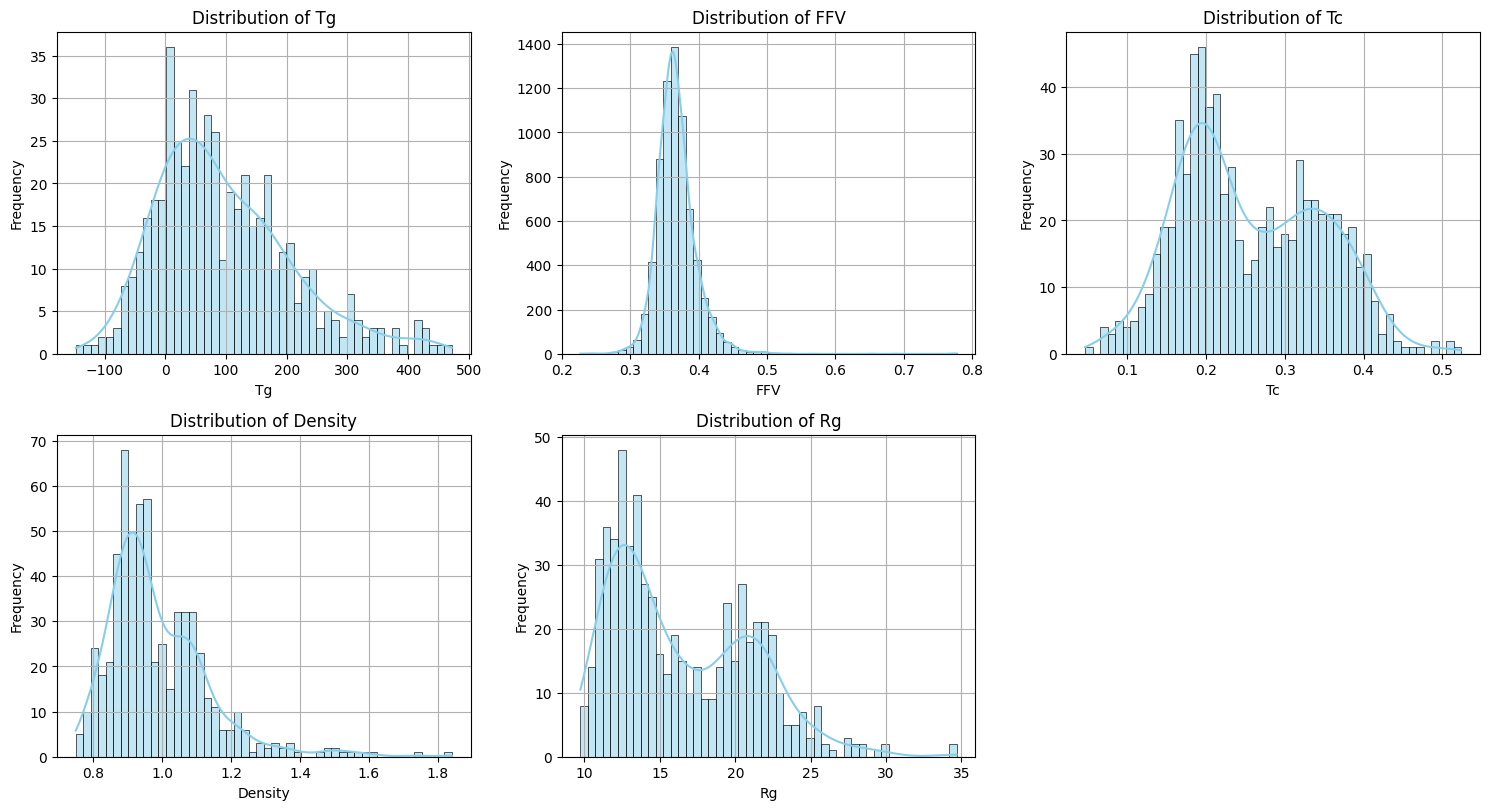

In [15]:
n_cols = 3
max_rows = 10  # Cap to prevent massive figures
n_rows = min((len(Y) + n_cols - 1) // n_cols, max_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Adjust how many plots to show if rows are capped
max_plots = n_rows * n_cols

for i, col in enumerate(Y[:max_plots]):
    sns.histplot(train_df[col], bins=50, kde=True, color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import re

# Clean SMILES strings by removing special characters: !@#%^&*=+{}[]<>?|
def clean_smiles(smiles):
    if isinstance(smiles, str):
        return re.sub(r'[!@#%^&*=+{}\[\]<>?|]',"", smiles)
    return smiles

# Apply the function to the 'SMILES' column of train_df
X['SMILES'] = train_df['SMILES'].apply(clean_smiles)
X.head(10)

,SMILES
0,CC()c1ccccc1C(O)OCCCCCC
1,Nc1ccc(CH(CCC)c2ccc(C3(c4ccc(CH(CCC)c5ccc(N)cc...
2,Oc1ccc(S(O)(O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(S(O...
3,Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N)c(...
4,Oc1ccc(OC(O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc(N(O)...
5,OC(O)CCCCCCCCC(O)OC1COC2C()COC12
6,Nc1ccc(CH2CH3CCH4CCH(C3)CCH2C4)cc1N
7,C(O)Nc1ccc(Oc2ccc(Oc3ccc(NC(O)c4ccc5c(c4)C(O)N...
8,CC()(C)C(O)OCCCCCCCCCOc1ccc2cc(C(O)Oc3ccccc3)c...
9,Nc1ccc(-c2ccc(-c3ccc(N)cc3)cc2)cc1


In [17]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from tqdm import tqdm


def extract_rdkit_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan] * 7
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        rdMolDescriptors.CalcNumAromaticRings(mol) / mol.GetNumAtoms()
    ]

features = [extract_rdkit_features(smi) for smi in tqdm(train_df['SMILES'], disable=True)]  # هنا تعطيل شريط التقدم

features_df = pd.DataFrame(features, columns=[
    "MolWt", "LogP", "HDonors", "HAcceptors", "TPSA", "RotBonds", "AromaticProp"
])

train_df = pd.concat([train_df.reset_index(drop=True), features_df], axis=1)

In [18]:
train_df.head()

,SMILES,Tg,FFV,Tc,Density,Rg,MolWt,LogP,HDonors,HAcceptors,TPSA,RotBonds,AromaticProp
0,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN,232.323,3.98170,0,2,26.30,8,0.052632
1,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN,598.919,12.35960,2,2,24.06,16,0.085106
2,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN,1003.207,14.21700,0,9,122.27,15,0.106667
3,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN,542.726,11.00768,2,2,24.06,7,0.136364
4,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN,965.154,11.84500,0,14,182.28,34,0.055556


In [19]:
train_df.shape

(7973, 13)

In [20]:
train_df.head(10)

,SMILES,Tg,FFV,Tc,Density,Rg,MolWt,LogP,HDonors,HAcceptors,TPSA,RotBonds,AromaticProp
0,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN,232.323,3.98170,0,2,26.30,8,0.052632
1,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN,598.919,12.35960,2,2,24.06,16,0.085106
2,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN,1003.207,14.21700,0,9,122.27,15,0.106667
3,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN,542.726,11.00768,2,2,24.06,7,0.136364
4,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN,965.154,11.84500,0,14,182.28,34,0.055556
5,*OC(=O)CCCCCCCCC(=O)OC1COC2C(*)COC12,NaN,0.339093,NaN,NaN,NaN,312.362,2.16190,0,6,71.06,10,0.000000
6,*Nc1ccc([C@H]2[C@@H]3C[C@H]4C[C@@H](C3)C[C@@H]...,NaN,0.347616,NaN,NaN,NaN,240.350,3.97870,2,2,24.06,3,0.050000
7,*C(=O)Nc1ccc(Oc2ccc(Oc3ccc(NC(=O)c4ccc5c(c4)C(...,NaN,0.377545,NaN,NaN,NaN,1163.296,16.00480,2,10,169.88,15,0.100000
8,*CC(*)(C)C(=O)OCCCCCCCCCOc1ccc2cc(C(=O)Oc3cccc...,NaN,0.359176,NaN,NaN,NaN,474.597,7.40720,0,5,61.83,15,0.081081
9,*Nc1ccc(-c2ccc(-c3ccc(N*)cc3)cc2)cc1,NaN,0.341878,NaN,NaN,NaN,258.324,4.77300,2,2,24.06,4,0.136364



Column: Tg
Q1 (25th percentile): 13.67
Q3 (75th percentile): 161.15
IQR: 147.47
Lower Bound: -207.54
Upper Bound: 382.36
Number of Outliers: 13


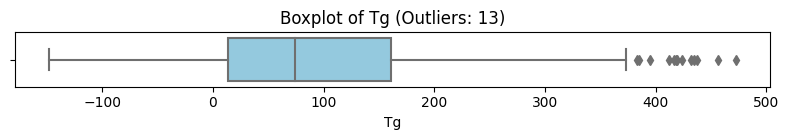


Column: FFV
Q1 (25th percentile): 0.35
Q3 (75th percentile): 0.38
IQR: 0.03
Lower Bound: 0.30
Upper Bound: 0.43
Number of Outliers: 269


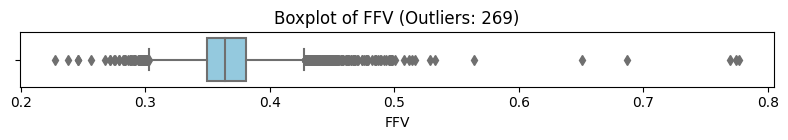


Column: Tc
Q1 (25th percentile): 0.19
Q3 (75th percentile): 0.33
IQR: 0.14
Lower Bound: -0.03
Upper Bound: 0.55
Number of Outliers: 0


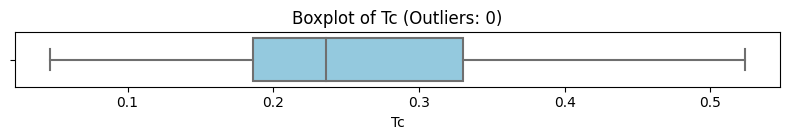


Column: Density
Q1 (25th percentile): 0.89
Q3 (75th percentile): 1.06
IQR: 0.17
Lower Bound: 0.63
Upper Bound: 1.32
Number of Outliers: 21


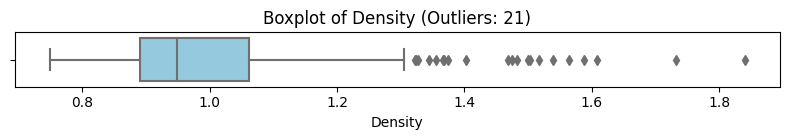


Column: Rg
Q1 (25th percentile): 12.54
Q3 (75th percentile): 20.41
IQR: 7.87
Lower Bound: 0.73
Upper Bound: 32.22
Number of Outliers: 2


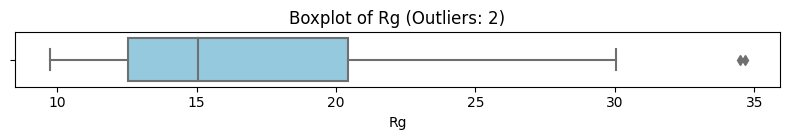

In [21]:
# Univariate Analysis (Single Variable)
Y_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# IQR-based Outlier Detection Function
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers, Q1, Q3, lower_bound, upper_bound

for col in Y_cols:
    print(f"\n{'='*60}")
    print(f"Column: {col}")

    # Detect outliers
    outliers, Q1, Q3, lower, upper = detect_outliers_iqr( train_df,col)


    # Summary Output
    print(f"Q1 (25th percentile): {Q1:.2f}")
    print(f"Q3 (75th percentile): {Q3:.2f}")
    print(f"IQR: {Q3 - Q1:.2f}")
    print(f"Lower Bound: {lower:.2f}")
    print(f"Upper Bound: {upper:.2f}")
    print(f"Number of Outliers: {len(outliers)}")

    # Visual: Boxplot
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(x=train_df[col], color='skyblue')
    plt.title(f'Boxplot of {col} (Outliers: {len(outliers)})')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [22]:
# Checking For Null values Again :
train_df.isnull().sum()

SMILES             0
Tg              7462
FFV              943
Tc              7236
Density         7360
Rg              7359
MolWt              0
LogP               0
HDonors            0
HAcceptors         0
TPSA               0
RotBonds           0
AromaticProp       0
dtype: int64

In [23]:
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout

feature_cols = ['MolWt', 'LogP', 'HDonors', 'HAcceptors', 'TPSA', 'RotBonds', 'AromaticProp']
target_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

def impute_with_nn(df, col):
    print(f"\n>> Column processing: {col}")
    valid_mask = (df[col].notna()) & (df[col] >= 0) if col == 'Tg' else df[col].notna()
    df_valid = df[valid_mask]

    if len(df_valid) < 30:
        mean_val = df_valid[col].mean()
        print(f" Too few samples ({len(df_valid)}), filling with mean: {mean_val:.3f}")
        df.loc[~valid_mask, col] = mean_val
        return df

    scaler = StandardScaler()
    X = scaler.fit_transform(df_valid[feature_cols])
    X_train, X_val, y_train, y_val = train_test_split(X, df_valid[col], test_size=0.2, random_state=42)
    act = {'Tg': 'relu', 'Rg': 'relu', 'FFV': 'sigmoid'}.get(col, 'tanh')

    model = Sequential([
        Dense(64, activation=act, input_shape=(X.shape[1],)), Dropout(0.2),
        Dense(32, activation=act), Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0)

    miss_mask = df[col].isna() | ((df[col] < 0) if col == 'Tg' else False)
    if miss_mask.sum() == 0:
        print(f" No missing/invalid values in {col}")
        return df

    preds = model.predict(scaler.transform(df[miss_mask][feature_cols])).flatten()
    df.loc[miss_mask, col] = preds
    print(f" Compensated {len(preds)} value(s) in {col}")
    return df

for col in target_cols:
    train_df = impute_with_nn(train_df, col)

train_df.to_csv("Train_df_new.csv", index=False)
print("\n The file has been saved after compensation under the name : Train_df_new.csv")


>> Column processing: Tg


2025-07-24 19:02:02.371546: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 Compensated 7551 value(s) in Tg

>> Column processing: FFV
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 Compensated 943 value(s) in FFV

>> Column processing: Tc
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 Compensated 7236 value(s) in Tc

>> Column processing: Density
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 Compensated 7360 value(s) in Density

>> Column processing: Rg
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
 Compensated 7359 value(s) in Rg

 The file has been saved after compensation under the name : Train_df_new.csv



Column: Tg
Q1 (25th percentile): 55.19
Q3 (75th percentile): 202.23
IQR: 147.04
Lower Bound: -165.37
Upper Bound: 422.80
Number of Outliers: 8


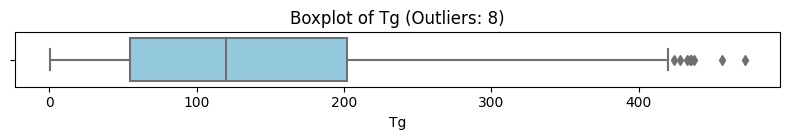


Column: FFV
Q1 (25th percentile): 0.35
Q3 (75th percentile): 0.38
IQR: 0.03
Lower Bound: 0.30
Upper Bound: 0.43
Number of Outliers: 239


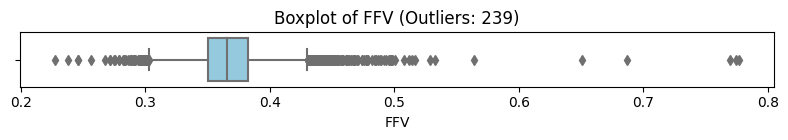


Column: Tc
Q1 (25th percentile): 0.20
Q3 (75th percentile): 0.29
IQR: 0.10
Lower Bound: 0.05
Upper Bound: 0.44
Number of Outliers: 20


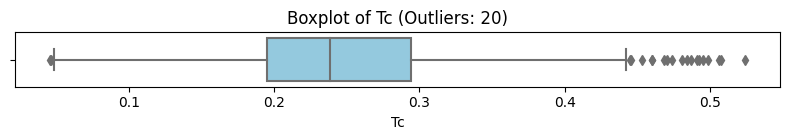


Column: Density
Q1 (25th percentile): 1.02
Q3 (75th percentile): 1.22
IQR: 0.20
Lower Bound: 0.72
Upper Bound: 1.52
Number of Outliers: 49


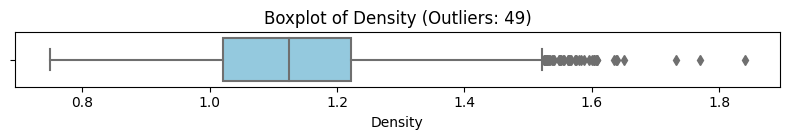


Column: Rg
Q1 (25th percentile): 15.32
Q3 (75th percentile): 20.59
IQR: 5.28
Lower Bound: 7.40
Upper Bound: 28.51
Number of Outliers: 190


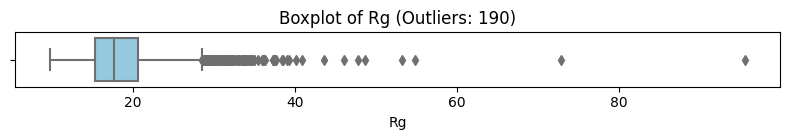

In [24]:
# Univariate Analysis (Single Variable)
Y_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# IQR-based Outlier Detection Function
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers, Q1, Q3, lower_bound, upper_bound

for col in Y_cols:
    print(f"\n{'='*60}")
    print(f"Column: {col}")

    # Detect outliers
    outliers, Q1, Q3, lower, upper = detect_outliers_iqr( train_df,col)


    # Summary Output
    print(f"Q1 (25th percentile): {Q1:.2f}")
    print(f"Q3 (75th percentile): {Q3:.2f}")
    print(f"IQR: {Q3 - Q1:.2f}")
    print(f"Lower Bound: {lower:.2f}")
    print(f"Upper Bound: {upper:.2f}")
    print(f"Number of Outliers: {len(outliers)}")

    # Visual: Boxplot
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(x=train_df[col], color='skyblue')
    plt.title(f'Boxplot of {col} (Outliers: {len(outliers)})')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

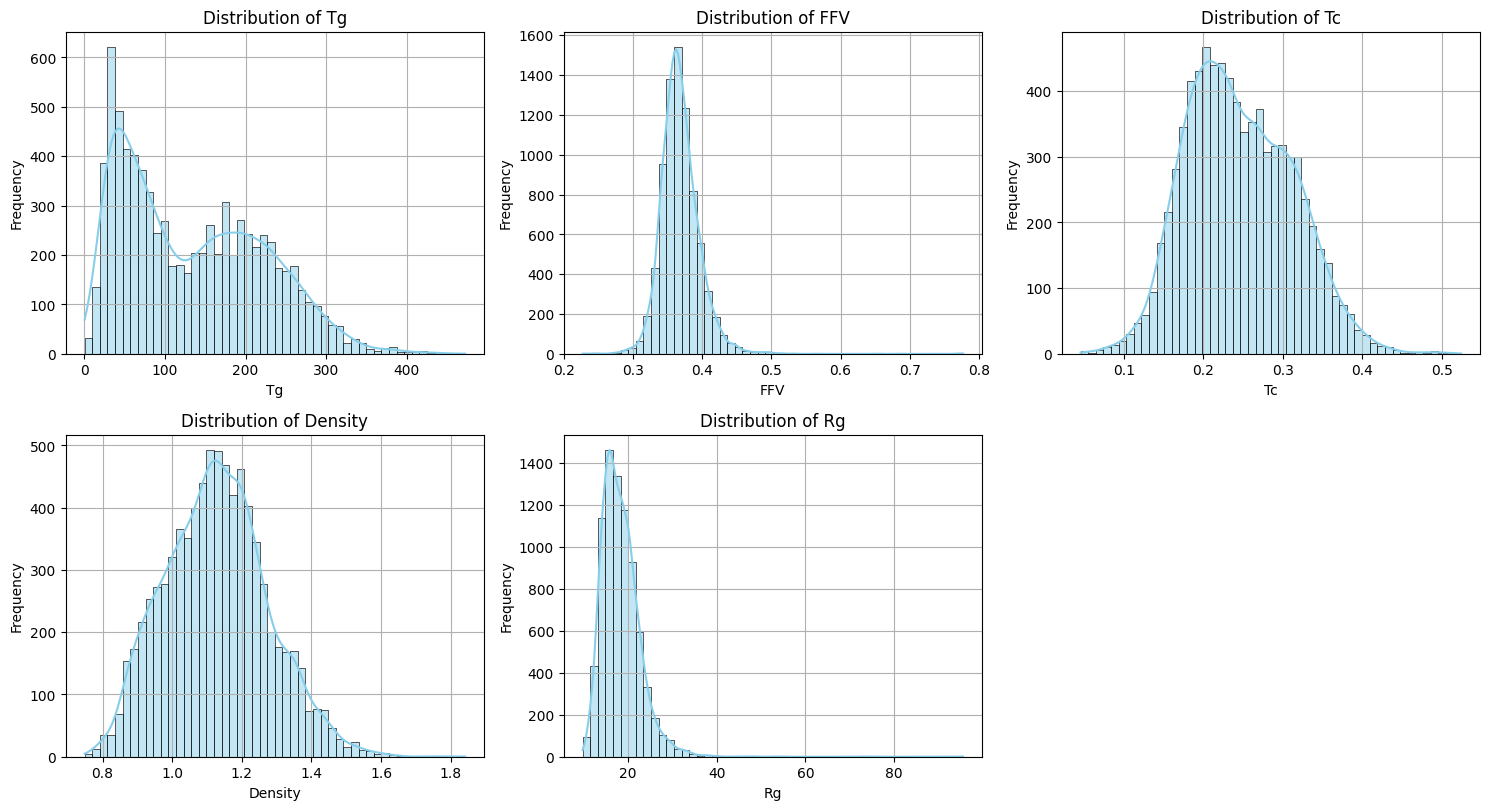

In [25]:
n_cols = 3
max_rows = 10  # Cap to prevent massive figures
n_rows = min((len(Y) + n_cols - 1) // n_cols, max_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Adjust how many plots to show if rows are capped
max_plots = n_rows * n_cols

for i, col in enumerate(Y[:max_plots]):
    sns.histplot(train_df[col], bins=50, kde=True, color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


                    Tg       FFV        Tc   Density        Rg     MolWt  \
Tg            1.000000  0.187207  0.062131  0.139590  0.457014  0.451053   
FFV           0.187207  1.000000  0.011911 -0.187886  0.016475  0.133869   
Tc            0.062131  0.011911  1.000000 -0.266786  0.397783  0.131652   
Density       0.139590 -0.187886 -0.266786  1.000000  0.200925  0.541048   
Rg            0.457014  0.016475  0.397783  0.200925  1.000000  0.641117   
MolWt         0.451053  0.133869  0.131652  0.541048  0.641117  1.000000   
LogP          0.398023  0.302862  0.326118  0.078112  0.520954  0.834455   
HDonors       0.249464 -0.350948  0.408042  0.048717  0.342191  0.053402   
HAcceptors    0.171806 -0.181091  0.066951  0.699913  0.565423  0.698771   
TPSA          0.245418 -0.253558  0.029574  0.732388  0.505622  0.679368   
RotBonds     -0.353784 -0.008423  0.407607  0.177997  0.438560  0.547291   
AromaticProp  0.758828  0.165274  0.361101  0.089792  0.398560  0.405202   

           

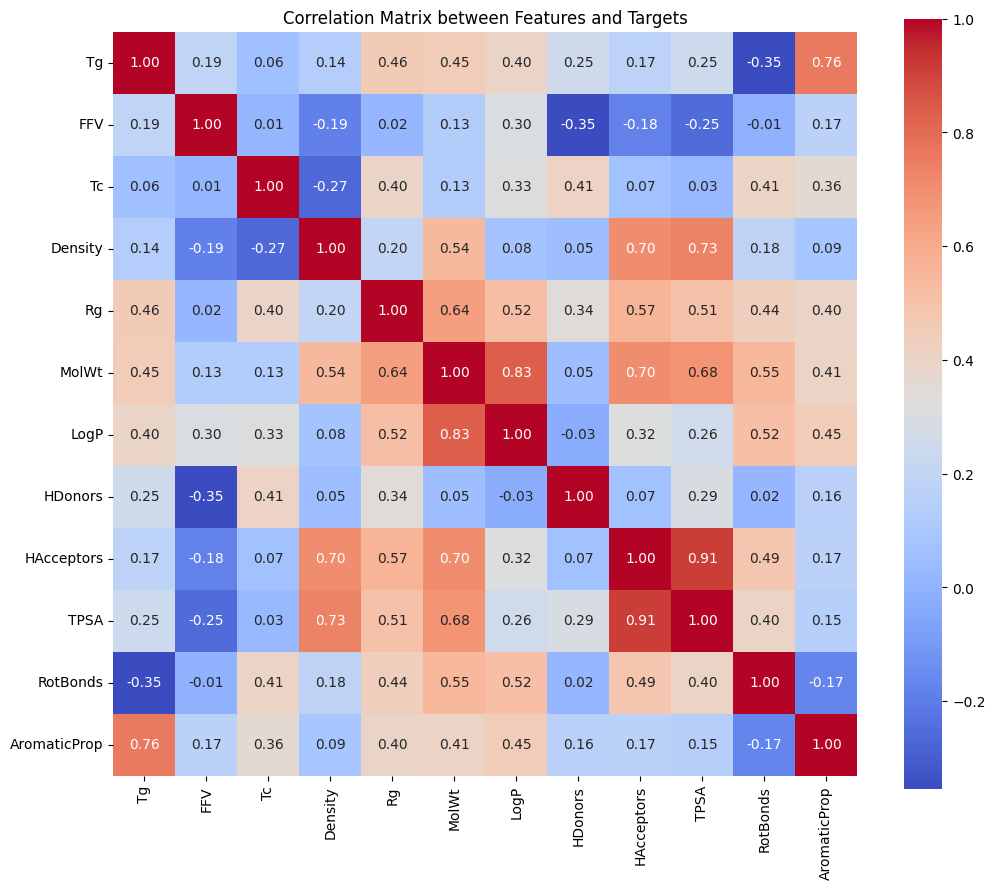

In [26]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg', 'MolWt', 'LogP', 'HDonors', 'HAcceptors', 'TPSA', 'RotBonds', 'AromaticProp']
corr = train_df[cols].corr()
print(corr)

plt.figure(figsize=(12,10))  # Correct place for figsize
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix between Features and Targets")
plt.show()

In [27]:
train_df.isnull().sum()
train_df.head()

,SMILES,Tg,FFV,Tc,Density,Rg,MolWt,LogP,HDonors,HAcceptors,TPSA,RotBonds,AromaticProp
0,*CC(*)c1ccccc1C(=O)OCCCCCC,41.396347,0.374645,0.205667,0.999233,12.351467,232.323,3.98170,0,2,26.30,8,0.052632
1,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,89.865921,0.370410,0.283114,0.915142,19.185266,598.919,12.35960,2,2,24.06,16,0.085106
2,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,229.492798,0.378860,0.190436,1.194387,26.854548,1003.207,14.21700,0,9,122.27,15,0.106667
3,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,240.513992,0.387324,0.321698,0.955762,20.515287,542.726,11.00768,2,2,24.06,7,0.136364
4,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,41.696712,0.355470,0.375884,1.389647,32.490177,965.154,11.84500,0,14,182.28,34,0.055556


In [28]:
train_df.shape

(7973, 13)

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7973 entries, 0 to 7972
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SMILES        7973 non-null   object 
 1   Tg            7973 non-null   float64
 2   FFV           7973 non-null   float64
 3   Tc            7973 non-null   float64
 4   Density       7973 non-null   float64
 5   Rg            7973 non-null   float64
 6   MolWt         7973 non-null   float64
 7   LogP          7973 non-null   float64
 8   HDonors       7973 non-null   int64  
 9   HAcceptors    7973 non-null   int64  
 10  TPSA          7973 non-null   float64
 11  RotBonds      7973 non-null   int64  
 12  AromaticProp  7973 non-null   float64
dtypes: float64(9), int64(3), object(1)
memory usage: 809.9+ KB


In [30]:
train_df.describe()

,Tg,FFV,Tc,Density,Rg,MolWt,LogP,HDonors,HAcceptors,TPSA,RotBonds,AromaticProp
count,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000
mean,134.167681,0.368061,0.245511,1.127323,18.303996,442.483920,5.572282,0.872445,4.414649,66.111084,9.006397,0.076824
std,87.686159,0.028836,0.066403,0.147602,4.323526,239.991773,3.702220,1.245024,2.920745,47.088447,6.465652,0.049768
min,0.336556,0.226992,0.045652,0.748691,9.728355,14.027000,-4.822900,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.190758,0.350644,0.195426,1.020844,15.316200,258.409000,2.904340,0.000000,2.000000,26.300000,5.000000,0.046154
50%,119.693420,0.365277,0.238732,1.125153,17.698145,406.357000,5.048500,0.000000,4.000000,58.200000,7.000000,0.083333
75%,202.233582,0.382532,0.294380,1.221431,20.592476,580.643000,7.458800,2.000000,6.000000,95.120000,12.000000,0.112903
max,472.250000,0.777097,0.524000,1.840999,95.559135,2202.482000,31.011400,9.000000,45.000000,437.260000,92.000000,0.250000


In [31]:
# Model Training

# Importing essential libraries for Build ML model
# Linear Models
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
    HuberRegressor,
    PassiveAggressiveRegressor
)

# Tree-based Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    BaggingRegressor
)

# Distance-based Model
from sklearn.neighbors import KNeighborsRegressor

# Margin-based Model
from sklearn.svm import SVR

# Probabilistic Model
from sklearn.gaussian_process import GaussianProcessRegressor

# Neural Network Model
from sklearn.neural_network import MLPRegressor


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Define your feature and target columns
feature_cols = ['MolWt', 'LogP', 'HDonors', 'HAcceptors', 'TPSA', 'RotBonds', 'AromaticProp']
target_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# Filter Step
print("Initial shape:", train_df.shape)

train_df = train_df[train_df['Tg'].notna()]                     # Remove rows where Tg is NaN
train_df = train_df[train_df['Tg'] >= 0]                        # Keep only Tg >= 0
train_df = train_df.dropna(subset=target_cols + feature_cols)  # Drop rows with NaNs in target or feature columns

print("After filtering shape:", train_df.shape)

# If DataFrame becomes empty, stop
if train_df.empty:
    raise ValueError("Filtered train_df is empty. Please check your data for missing values or all Tg < 0.")

# Prepare X and y
X = train_df[feature_cols]
y = train_df[target_cols]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initializing a dictionary of classification models for training and evaluation
# Define regression models
models = {

    # Linear Models
    "Linear Regression": LinearRegression(),  # Simple linear regression for modeling linear relationships
    "Ridge Regression": Ridge(),  # Linear regression with L2 regularization to prevent overfitting
    "Lasso Regression": Lasso(),  # Linear regression with L1 regularization for feature selection
    "ElasticNet": ElasticNet(),  # Combines L1 and L2 regularization for balanced shrinkage and sparsity
    "Bayesian Ridge": BayesianRidge(),  # Bayesian version of linear regression with probabilistic outputs
    "Huber Regressor": HuberRegressor(),  # Robust linear regression that handles outliers well
    "Passive Aggressive Regressor": PassiveAggressiveRegressor(max_iter=1000, random_state=42),  # Online learning model for large-scale regression

    # Tree-based Models
    "Decision Tree": DecisionTreeRegressor(random_state=42),  # Non-linear model using recursive tree structure
    "Random Forest": RandomForestRegressor(random_state=42),  # Ensemble of decision trees using bagging
    "Extra Trees": ExtraTreesRegressor(random_state=42),  # Extremely randomized trees for faster, decorrelated ensemble

    # Boosting Models
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),  # Sequential ensemble boosting trees
    "AdaBoost": AdaBoostRegressor(random_state=42),  # Adaptive boosting that focuses on difficult examples
    "Bagging Regressor": BaggingRegressor(random_state=42),  # Bootstrap aggregation of regressors for variance reduction

    # Distance-based Model
    "K-Nearest Neighbors": KNeighborsRegressor(),  # Predicts target based on average of nearest neighbors

    # Margin-based Model
    "Support Vector Regressor": SVR(),  # Regression model that fits within a margin using kernel trick

    # Probabilistic Model
    "Gaussian Process Regressor": GaussianProcessRegressor(),  # Non-parametric, kernel-based probabilistic regression

    # Neural Network Model
    "MLP Regressor (Neural Net)": MLPRegressor(random_state=42, max_iter=1000)  # Multi-layer perceptron for capturing complex non-linear relationships
 }

# Train & evaluate each model
for name, model in models.items():
    model = MultiOutputRegressor(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n {name} Results:")
    for i, col in enumerate(target_cols):
        r2 = r2_score(y_test[col], y_pred[:, i])
        mse = mean_squared_error(y_test[col], y_pred[:, i])
        rmse = np.sqrt(mse)
        print(f"  - {col}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

Initial shape: (7973, 13)
After filtering shape: (7973, 13)

 Linear Regression Results:
  - Tg: R² = 0.8538, RMSE = 33.5221
  - FFV: R² = 0.3433, RMSE = 0.0214
  - Tc: R² = 0.7210, RMSE = 0.0350
  - Density: R² = 0.7599, RMSE = 0.0736
  - Rg: R² = 0.6186, RMSE = 2.5655

 Ridge Regression Results:
  - Tg: R² = 0.8538, RMSE = 33.5231
  - FFV: R² = 0.3433, RMSE = 0.0214
  - Tc: R² = 0.7210, RMSE = 0.0350
  - Density: R² = 0.7600, RMSE = 0.0736
  - Rg: R² = 0.6186, RMSE = 2.5656

 Lasso Regression Results:
  - Tg: R² = 0.8525, RMSE = 33.6747
  - FFV: R² = -0.0013, RMSE = 0.0264
  - Tc: R² = -0.0000, RMSE = 0.0662
  - Density: R² = -0.0000, RMSE = 0.1502
  - Rg: R² = 0.4189, RMSE = 3.1668

 ElasticNet Results:
  - Tg: R² = 0.7505, RMSE = 43.7875
  - FFV: R² = -0.0013, RMSE = 0.0264
  - Tc: R² = -0.0000, RMSE = 0.0662
  - Density: R² = -0.0000, RMSE = 0.1502
  - Rg: R² = 0.4831, RMSE = 2.9867

 Bayesian Ridge Results:
  - Tg: R² = 0.8538, RMSE = 33.5232
  - FFV: R² = 0.3436, RMSE = 0.0214
 

### Based on the evaluation metrics across all five target properties (Tg, FFV, Tc, Density, and Rg), the MLP Regressor (Neural Network) consistently delivers the highest R² scores and lowest RMSE values overall—especially for Tg, Rg, and Density. While models like Random Forest, Extra Trees, and Bagging Regressor also perform exceptionally well and show strong generalization, the MLP outperforms in terms of accuracy for most targets. <br>

### Hence, if interpretability is not a major constraint, the MLP Regressor is the best choice for this regression task due to its superior predictive power and ability to capture complex, non-linear relationships in the polymer data.

In [33]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski, rdMolDescriptors
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
import joblib  # for model and scaler saving/loading if needed

# Load the test data
test_df = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/test.csv')

# Define the feature extraction function
def extract_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan] * 7
    return [
        Descriptors.MolWt(mol),
        Crippen.MolLogP(mol),
        Lipinski.NumHDonors(mol),
        Lipinski.NumHAcceptors(mol),
        rdMolDescriptors.CalcTPSA(mol),
        Lipinski.NumRotatableBonds(mol),
        Chem.rdMolDescriptors.CalcNumAromaticRings(mol) / mol.GetNumAtoms() if mol.GetNumAtoms() > 0 else 0
    ]

# Feature columns
feature_cols = ['MolWt', 'LogP', 'HDonors', 'HAcceptors', 'TPSA', 'RotBonds', 'AromaticProp']
target_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# Extract features for each SMILES
test_df[feature_cols] = test_df['SMILES'].apply(lambda x: pd.Series(extract_features(x)))

# Drop rows with missing features
test_df = test_df.dropna(subset=feature_cols)

# Scale using the same scaler as training
# Load pre-fitted scaler or define again if in the same script
# scaler = StandardScaler()
# scaler.fit(X_train)  # Only if not already fit
# If you saved the scaler earlier, you can load it with joblib.load('scaler.pkl')
X_test_scaled = scaler.transform(test_df[feature_cols])

# Define and train the model (or load if pre-trained)
mlp_model = MultiOutputRegressor(MLPRegressor(random_state=42, max_iter=1000))
mlp_model.fit(X_train, y_train)  # Only if not already trained
# If already trained and saved: mlp_model = joblib.load('mlp_model.pkl')

# Make predictions
preds = mlp_model.predict(X_test_scaled)

# Create the final prediction DataFrame
pred_df = pd.DataFrame(preds, columns=target_cols)
final_df = pd.concat([test_df[['SMILES']].reset_index(drop=True), pred_df], axis=1)

# Save to CSV
final_df.to_csv('submission.csv', index=False)
print("Saved predictions as: submission.csv")

Saved predictions as: submission.csv


In [34]:
submission_df = pd.read_csv("submission.csv")
submission_df.head()

,SMILES,Tg,FFV,Tc,Density,Rg
0,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...,151.785838,0.385314,0.226406,1.155255,18.019986
1,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...,147.690574,0.372652,0.262205,1.114361,18.990698
2,*c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...,74.337965,0.340996,0.220928,1.244085,17.348854
